In [1]:
# Imports
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
import networkx as nx
from shapely.geometry import LineString, Point, Polygon, MultiPoint
from shapely.ops import nearest_points
from shapely.ops import unary_union
from shapely import speedups
from geopy.geocoders import Nominatim
from geopandas.tools import geocode
from geopy.extra.rate_limiter import RateLimiter
import datetime
import folium
import geojson

%matplotlib inline

## 1.
Travel times

Functioning locations: 
- Yliopistonkatu 3 = Porthania
- Haartmaninkatu 8 = Meilahti
- Gustaf Hällströmin katu 2 = Kumpula
- Viikinkaari 11 = Viikki

In [2]:
epsg=3067

In [3]:
# An example
#orig_address = 'Yliopistonkatu 3'+', Helsinki, Finland'
#dest_address = 'Viikinkaari 11'+', Helsinki, Finland'
#transport_method = 'car'
#user_time = 'Now'

# User-defined addresses, transportation method and departure time
orig_address = str(input('Origin address (street name and number):')+', Helsinki, Finland')
dest_address = str(input('Destination address (street name and number):')+', Helsinki, Finland')
transport_method = str(input('transportation method (walk, bike, public, or car):').lower()) 
user_time = str(input('Departure time (hours:minutes)\n(write "now" or leave this field empty to use current time in Helsinki as departure time):').lower())

# Geocode addresses
orig_point = geocode(orig_address, provider='nominatim', user_agent='autogis_EH', timeout=10)
dest_point = geocode(dest_address, provider='nominatim', user_agent='autogis_EH', timeout=10)

# Project to ETRS-TM35FIN
orig_point = orig_point.to_crs(epsg=epsg)
dest_point = dest_point.to_crs(epsg=epsg)

# Define current time in Helsinki (UTC + 2 hours)
time_hki = datetime.datetime.utcnow()+datetime.timedelta(hours=2)

# Set start time for the trip conditionally
if not user_time or user_time == 'now':
    # Use current Helsinki time as start time
    time_start = time_hki
else:
    # String slice user-defined time to a datetime object and use that as start time instead
    user_hour = int(user_time[0:2])
    user_min = int(user_time[3:5])
    time_start = datetime.datetime(year=time_hki.year,
                                   month=time_hki.month,
                                   day=time_hki.day,
                                   hour=user_hour,
                                   minute=user_min
                                  )

Origin address (street name and number): Viikinkaari 11
Destination address (street name and number): Haartmaninkatu 8
transportation method (walk, bike, public, or car): walk
Departure time (hours:minutes)
(write "now" or leave this field empty to use current time in Helsinki as departure time): 


In [4]:
# Read in the YKR grid
fp_grid = r'data/YKR/MetropAccess_YKR_grid_EurefFIN.shp'
grid = gpd.read_file(fp_grid)

# Check projections
if grid.crs == orig_point.crs == dest_point.crs:
    print('data is correctly projected')
else:
    print('projections do not match')

data is correctly projected


In [5]:
# Define centroids of all of the YKR grid cells

# Dataframe for centroids
grid_centroids = gpd.GeoDataFrame()

# Define a centroid for every grid cell based on the pre existing x and y columns in the Travel time matrix
grid_centroids['geometry'] = gpd.points_from_xy(grid.x, grid.y)

# Keep the YKR_ID for data selection
grid_centroids['YKR_ID'] = grid['YKR_ID']

# Check Results
grid_centroids.head()

,geometry,YKR_ID
0,POINT (381875.000 6697880.000),5785640
1,POINT (382125.000 6697880.000),5785641
2,POINT (382375.000 6697880.000),5785642
3,POINT (382625.000 6697880.000),5785643
4,POINT (381125.000 6697630.000),5787544


To get the the **YKR_ID** value of the cell centroids that are nearest to both the origin and destination point I use a function from lesson 3

In [6]:
# Defining a function for getting the YKR_ID values of the nearest cell centroids
def get_nearest_values(row, other_gdf, point_column='geometry', value_column='geometry'):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf['geometry'].unary_union
    
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf['geometry'] == nearest_geoms[1]]
    
    nearest_value = nearest_data[value_column].values[0]
    
    return nearest_value

In [7]:
# Applying the function 

# Finding closest centroid to orig_point 
orig_point['YKR_ID'] = orig_point.apply(
    get_nearest_values,
    other_gdf=grid_centroids,
    point_column='geometry',
    value_column='YKR_ID',
    axis=1
    )

# Finding closest centroid to dest_point
dest_point['YKR_ID'] = dest_point.apply(
    get_nearest_values,
    other_gdf=grid_centroids,
    point_column='geometry',
    value_column='YKR_ID',
    axis=1
    )

# Assigning YKR_IDs to variables
orig_YKR = orig_point['YKR_ID'].iloc[0]
dest_YKR = dest_point['YKR_ID'].iloc[0]

# Check results
print(orig_YKR, dest_YKR)

5931307 5960105


In [8]:
# Select apprpriate travel time data based on dest_point's YKR_ID (Only 4/13 231 possible files uploaded to git)
fp_tt = r'data/traveltimes/travel_times_to_ '+str(dest_YKR)+'.txt'

# Read in data
tt_data = pd.read_csv(fp_tt, sep=';', na_values=['-1'])

# Merge travel time data to YKR grid
tt_grid = grid.merge(tt_data, on=tt_data['from_id'])
tt_grid.columns

Index(['key_0', 'x', 'y', 'YKR_ID', 'geometry', 'from_id', 'to_id', 'walk_t',
       'walk_d', 'bike_s_t', 'bike_f_t', 'bike_d', 'pt_r_tt', 'pt_r_t',
       'pt_r_d', 'pt_m_tt', 'pt_m_t', 'pt_m_d', 'car_r_t', 'car_r_d',
       'car_m_t', 'car_m_d', 'car_sl_t'],
      dtype='object')

In [9]:
# Select the grid cell that has the information of the total duration of the trip from orig_point to dest_point
time_cell = tt_grid.loc[tt_grid['YKR_ID']==orig_YKR]

# Define the column to be used in the calculation based on user input and current time of the day
if transport_method == 'walk':
    column = 'walk_t'
if transport_method == 'bike':
    column = 'bike_s_t'
    
# The column selection for public transportation and car takes the rush hours into account (but not on sundays!)
if transport_method == 'public':
    if 8 <= time_start.hour <= 9 or 16 <= time_start.hour <= 18 and time_start.weekday() % 6 != 0:
        column = 'pt_r_t'
        traffic_forecast = 'Rush hour'
    else:
        column = 'pt_m_t'
        traffic_forecast = 'Normal traffic'
if transport_method == 'car':
    if 8 <= time_start.hour <= 9 or 16 <= time_start.hour <= 18 and time_start.weekday() % 6 != 0:
        traffic_forecast = 'Rush hour'
        column = 'car_r_t'
    else:
        traffic_forecast = 'Normal traffic'
        column = 'car_m_t'

# Get travel time as minutes
travel_time = time_cell[column].iloc[0]

# Format travel time for cleaner output later on
if travel_time >= 60:
    tt_h = int(travel_time // 60)
    tt_min = int(travel_time % 60)
    travel_time_formatted = str(tt_h)+' h '+str(tt_min)+' min'
else:
    travel_time_formatted = str(travel_time)+' min'
# Test print
print('the trip will take approximately '+
      travel_time_formatted)

the trip will take approximately 1 h 52 min


In [10]:
time_start.weekday() % 12

6

In [11]:
# ETA

# Estimated time of arrival 
eta = time_start + datetime.timedelta(minutes=travel_time)

# Format current and arrival time to hours + minutes for output later on
if time_start.hour >= 10:
    hour_now = str(time_start.hour)
else:
    hour_now = '0'+str(time_start.hour)

if time_start.minute >= 10:
    minute_now = str(time_start.minute)
else:
    minute_now = '0'+str(time_start.minute)
    
time_start_formatted = hour_now + ':'+ minute_now

if eta.hour >= 10:
    hour_eta = str(eta.hour)
else:
    hour_eta = '0'+str(eta.hour)

if eta.minute >= 10:
    minute_eta = str(eta.minute)
else:
    minute_eta = '0'+str(eta.minute)
    
time_start_formatted = hour_now +':'+ minute_now
eta_formatted = hour_eta+':'+minute_eta
    
# Test print
print('Departure time: '+
      time_start_formatted+
      '\n\nEstimated time of arrival: '+
      eta_formatted
     )

Departure time: 18:41

Estimated time of arrival: 20:33


## 2.
Path

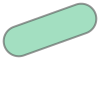

In [12]:
# orig and dest points to wgs
orig_point_wgs = orig_point.to_crs(epsg=4326)
dest_point_wgs = dest_point.to_crs(epsg=4326)

# Combine the dest and orig points
extent_points = orig_point_wgs.append(dest_point_wgs)

# Create a convex hull
graph_extent = extent_points.unary_union.convex_hull

# Conditional buffer to limit network size for walking
if transport_method == 'walk':
    buffer = 0.025
else:
    buffer = 0.05

graph_extent = graph_extent.buffer(buffer)

# Check results
graph_extent

In [13]:
# Select OSM network type conditionally
if transport_method == 'walk':
    network = 'walk'
if transport_method == 'bike':
    network = 'bike'
if transport_method == 'public':
    network = 'drive'
if transport_method == 'car':
    network = 'drive'

# Get graph
graph = ox.graph_from_polygon(graph_extent, network_type=network)

In [14]:
# Project graph to UTM zone 35
graph_utm = ox.project_graph(graph)
nodes_utm, edges_utm = ox.graph_to_gdfs(graph_utm, nodes=True, edges=True)

# Project points to UTM zone 35
orig_point_utm = orig_point.to_crs(edges_utm.crs)
dest_point_utm = dest_point.to_crs(edges_utm.crs)

In [15]:
# Create GDF with a geometry column for the route
routes = gpd.GeoDataFrame()
routes['geometry'] = None

# Select origin y and x
orig_yx = (orig_point_utm['geometry'].iloc[0].y, orig_point_utm['geometry'].iloc[0].x)
# Get node id
orig_node_id = ox.get_nearest_node(graph_utm, orig_yx, method='euclidean')
# Get node
orig_node = nodes_utm.loc[orig_node_id]

# Select destination y and x
dest_yx = (dest_point_utm['geometry'].iloc[0].y, dest_point_utm['geometry'].iloc[0].x)
# Get node id
dest_node_id = ox.get_nearest_node(graph_utm, dest_yx, method='euclidean')
# Get node
dest_node = nodes_utm.loc[dest_node_id]

# Only calculate route when the start and destination node IDs are different
if dest_node_id != orig_node_id:
    # Get shortest path
    route = nx.shortest_path(graph_utm, source=orig_node_id, target=dest_node_id, weight='length')
    # Get route nodes
    route_nodes = nodes_utm.loc[route]
    # Construct route line
    route_line = LineString(list(route_nodes.geometry.values))
    # Add line to lines column
    routes.at[0, 'geometry'] = route_line
    
# Define routes crs
routes.crs = edges_utm.crs
# Check results
routes.crs

<Projected CRS: +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Visual test of solution so far

At this point I check if my solution makes sense. I do this by by plotting the origin and destination points, their nearest grid cells and the road graph as a simple map.

In [16]:
# Select the cells
orig_cell = tt_grid['geometry'].loc[tt_grid['YKR_ID'] == orig_YKR]
dest_cell = tt_grid['geometry'].loc[tt_grid['YKR_ID'] == dest_YKR]

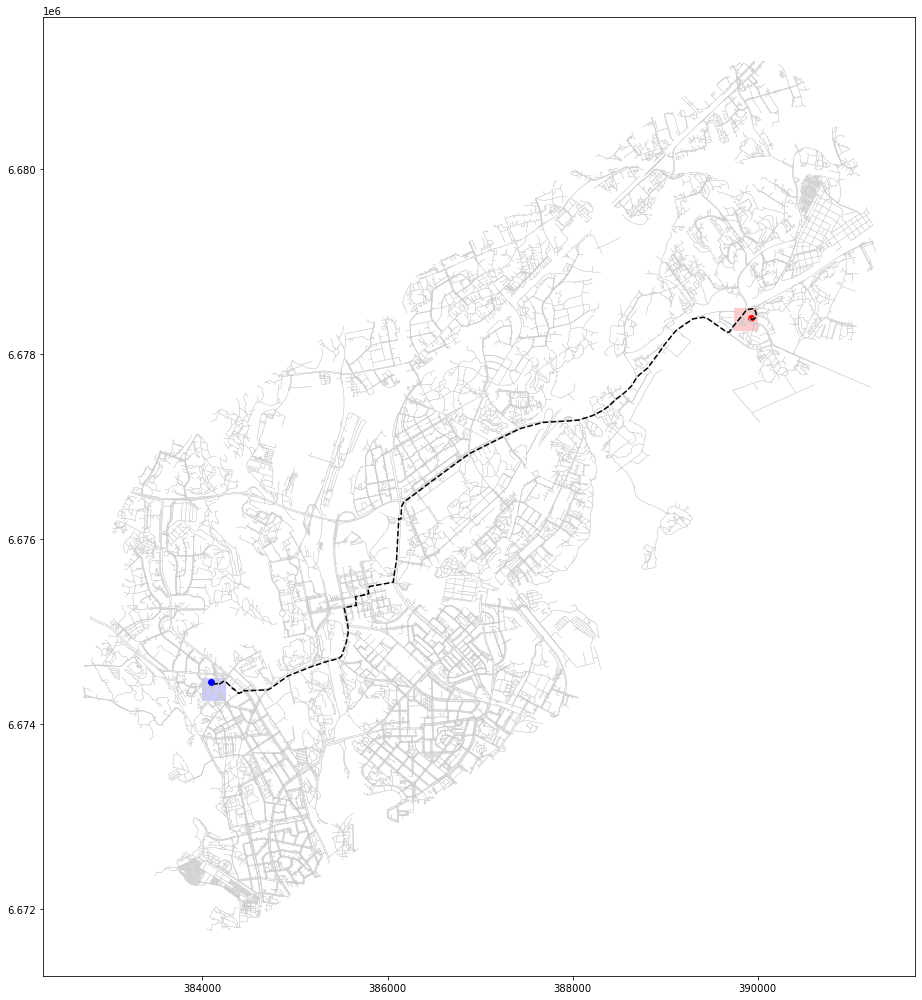

In [17]:
# Set up the plot
fig, ax = plt.subplots(figsize=(20,14))

# Plot graph edges
edges_utm.plot(ax=ax, color=[0.8,0.8,0.8], linewidth=0.4)

# Plot grid cells
orig_cell.plot(ax=ax, facecolor=[1,0.8,0.8])
dest_cell.plot(ax=ax, facecolor=[0.8,0.8,1])

# Plot route
routes.plot(ax=ax, color=[0,0,0], linestyle='--')

# Plot points
orig_point.plot(ax=ax, color=[1,0,0])
dest_point.plot(ax=ax, color=[0,0,1])

plt.tight_layout()

## 3. Visualization
At this point I have all of the data that i need to plot an interactive map of the route and it's information

In [18]:
# Prepare data for the plotting of the interactive map
routes_wm = routes.to_crs(epsg=3857)
orig_point_wm = orig_point.to_crs(epsg=3857)
dest_point_wm = dest_point.to_crs(epsg=3857)

In [20]:
# Create a map instance
m = folium.Map(
    # Background map
    tiles='CartoDB positron',
    overlay=True,
    control_scale=True
)


# Add the route line to the map with quite counter-intuitive syntax
folium.Choropleth(
    routes_wm[routes_wm.geometry.length>0.001],
    line_weight=3,
    line_color='cadetblue'
).add_to(m)
 

# Define orig and dest point tooltips
orig_tooltip = ('Origin<br><br>Address: '+
                orig_address+
                '<br>Departure time: '+
                time_start_formatted
               )
dest_tooltip = ('Destination<br><br>Address: '+ 
                dest_address+
                '<br>Estimated arrival time: '+
                eta_formatted
               )

# Define route length for route tooltip
route_length = int(routes['geometry'].iloc[0].length,)

# Define route tooltip (add traffic forecast only if transport method is affected by road traffic)
if transport_method == 'public' or transport_method == 'car':
    route_tooltip = ('Shortest route <br><br>Distance: '+
                     str(route_length)+
                     ' m<br>Travel time: '+
                     travel_time_formatted+
                     '<br>Travel mode: '+
                     transport_method+
                     '<br>Estimated traffic: '+
                     traffic_forecast
                    )
else:
    route_tooltip = ('Shortest route <br><br>Distance: '+
                     str(route_length)+
                     ' m<br>Travel time: '+
                     travel_time_formatted+
                     '<br>Travel mode: '+
                     transport_method
                    )



# Add markers

# Get the origin and destination points in yx format and in wgs 
orig_point_wgs_yx = [orig_point_wgs['geometry'].iloc[0].y, orig_point_wgs['geometry'].iloc[0].x]
dest_point_wgs_yx = [dest_point_wgs['geometry'].iloc[0].y, dest_point_wgs['geometry'].iloc[0].x]

# Origin
folium.Marker(
    orig_point_wgs_yx,
    tooltip=orig_tooltip,
    icon=folium.Icon(icon='arrow-up', color='red')
).add_to(m)

# Destination
folium.Marker(
    dest_point_wgs_yx,
    tooltip=dest_tooltip,
    icon=folium.Icon(icon='arrow-down', color='blue')
).add_to(m)

# Add a transparent version of the route line with higher weight parameter (this results in a bigger area to hover the route with the mouse when viewing the map) 
folium.features.GeoJson(routes_wm,
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':45},
                        tooltip=route_tooltip,
                       ).add_to(m)


# Zoom and center the map view based on the extent of the orig and dest point
m.fit_bounds([orig_point_wgs_yx, dest_point_wgs_yx]) 

# Display map
m